# Models for ozone 

In this notebook, we develop the models for the transformed dataset considering the exogenous variable to be the **Ozone**.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import os
import tqdm
from utilities import Utilities

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# models 
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression
import statsmodels.api as sm
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# others
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures

from scipy.stats import jarque_bera

## Definitions for the notebook

In [4]:
# For local folder
IMAGES_FOLDER = "../notes/images/"
# For Google colab
#IMAGES_FOLDER = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/images/"

sns.set()

pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

utility = Utilities()

%matplotlib inline

## Importing the dataset

In [5]:
# For local folder
location = "../data/"
# For Google colab
#location = "drive/MyDrive/Arquivos Acadêmicos/Disciplinas FGV/Machine Learning/"

air_data = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p3.csv", index_col = 0)
air_data.weekend = air_data.weekend.astype(int)
air_data = air_data.reset_index().drop(columns="index")
air_data.head()

,year,month,day,CodNum,Lat,Lon,Chuva,Pres,RS,Temp,...,CO_lag24,CO_MA24,O3_lag1,O3_lag2,O3_lag24,O3_MA24,PM10_lag1,PM10_lag2,PM10_lag24,PM10_MA24
0,2011,1,2,1,-22.965,-43.180,3.617,-1.530,-1.128,-0.140,...,-0.763,-0.936,-0.738,-0.543,-1.190,-0.365,0.101,0.078,0.087,0.082
1,2011,1,2,7,-22.898,-43.222,-0.272,-1.513,-0.565,0.560,...,-1.678,-1.232,-0.612,-0.997,-0.724,-0.187,-0.307,-0.967,-1.858,-1.136
2,2011,1,2,3,-22.908,-43.178,3.617,-1.557,-0.720,-0.470,...,-0.634,-0.166,-0.211,-0.717,-0.169,-0.027,-0.677,-0.677,-1.617,-1.141
3,2011,1,2,8,-22.925,-43.233,3.617,-1.909,-0.194,-1.068,...,-0.897,-1.283,-0.267,-0.184,-1.028,0.274,-0.773,-0.583,0.495,-1.061
4,2011,1,2,7,-22.898,-43.222,3.617,-1.658,-0.567,0.548,...,-1.591,-1.206,-1.300,-0.612,-1.099,-0.204,-0.484,-0.307,-0.967,-1.136


## Inverse Power Transformation 

In [6]:
air_data_ = pd.read_csv(location + "RiodeJaneiro_MonitorAr_hourly_p2.csv", index_col = 0)

gases = ['CO', 'O3', 'PM10']

pt_gases = {key: PowerTransformer(method = 'yeo-johnson', 
                                  standardize=True).fit(air_data_[[key]]) for key in gases}

del air_data_

## Train and Test

In [7]:
df_train = air_data[air_data.train].drop(columns='train')
df_test = air_data[~air_data.train].drop(columns='train')

x_train = df_train.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])
x_test = df_test.drop(columns=["O3", 'CO', 'PM10', 'aiq', 'Lat', 'Lon'])

## Tijuca station

The chosen station to report more detailed results.

In [8]:
x_train_SP = x_train[x_train.CodNum == 8].drop(columns="CodNum")
x_test_SP = x_test[x_test.CodNum == 8] .drop(columns="CodNum")

y_train_o3 = df_train[df_train.CodNum==8].O3
y_test_o3 = df_test[df_test.CodNum==8].O3

del df_train, df_test

## Linear regression

In [60]:
x_train_SP_sm = sm.add_constant(x_train_SP)
x_test_SP_sm = sm.add_constant(x_test_SP)

reg = sm.OLS(y_train_o3, x_train_SP_sm)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 1.199e+04
Date:                Sat, 19 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:23:18   Log-Likelihood:                -20194.
No. Observations:               54290   AIC:                         4.044e+04
Df Residuals:                   54263   BIC:                         4.068e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.2878      2.546     12.681      0.0

In [61]:
y_pred = res.predict(x_test_SP_sm)

y_train_pred = res.predict(x_train_SP_sm)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "simple_linear_regression", {},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8517668189656552
MAE train set: 0.25780109884853836
RMSE train set: 0.350999594200755
R2 test set: 0.8370700290526956
MAE test set: 0.22463310207015727
RMSE test set: 0.3039159513047826


Let's look at the residuals

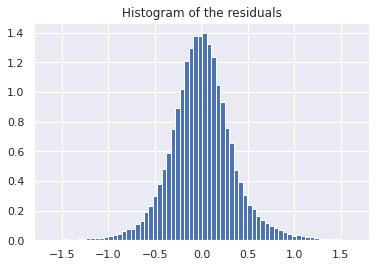

In [62]:
residuals = y_train_pred - y_train_o3
plt.hist(residuals, bins = 100, density = True)
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.savefig(IMAGES_FOLDER+"histogram_residuals_slr.eps", bbox_inches = 'tight')
plt.show()

In [10]:
print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

Skew: 0.22558431082476935
Kurt: 2.8041868083755976
Jarque-Bera: Jarque_beraResult(statistic=18243.56064834909, pvalue=0.0)


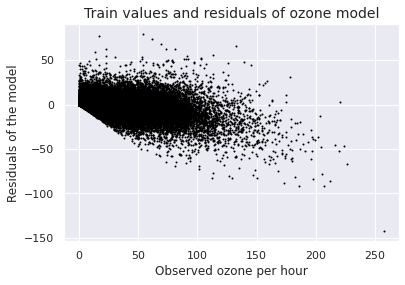

In [11]:
train_trans = pt_gases['O3'].inverse_transform(y_train_o3.values.reshape(-1,1))
pred_trans = pt_gases['O3'].inverse_transform(y_train_pred.values.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'black')
plt.xlabel("Observed ozone per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of ozone model", fontsize = 14)
plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


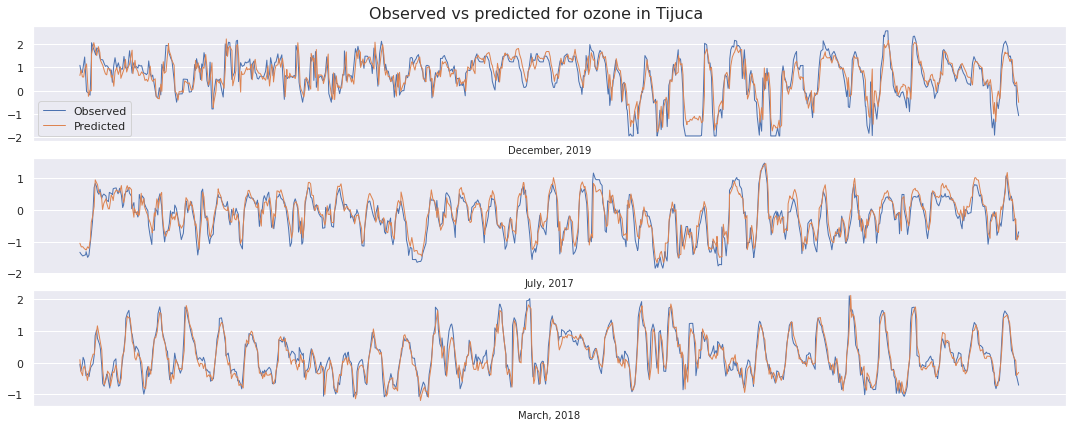

In [12]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_o3[rows1.index], linewidth = 1, label = 'Observed')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted')
ax[1].plot(rows2.index, y_test_o3[rows2.index], linewidth = 1)
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1)
ax[2].plot(rows3.index, y_test_o3[rows3.index], linewidth = 1)
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1)

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for ozone in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 10)
ax[1].set_xlabel("July, 2017", fontsize = 10)
ax[2].set_xlabel("March, 2018", fontsize = 10)

ax[0].legend()

plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

In [13]:
x_train_SP_sm = sm.add_constant(x_train_SP.drop(columns=['O3_lag1','CO_lag1','PM10_lag1',
                                                       'O3_lag2','CO_lag2','PM10_lag2',
                                                        'O3_lag24','CO_lag24','PM10_lag24',
                                                       'O3_MA24','CO_MA24','PM10_MA24']))
x_test_SP_sm = sm.add_constant(x_test_SP.drop(columns=['O3_lag1','CO_lag1','PM10_lag1',
                                                       'O3_lag2','CO_lag2','PM10_lag2', 
                                                       'O3_lag24','CO_lag24','PM10_lag24',
                                                       'O3_MA24','CO_MA24','PM10_MA24']))
test_values = [1,2,4,8,12,24,36,48,60,72,84,108]
r2_test_values = []

for i in test_values:
    
    x_train_SP_sm["O3_lag"] = y_train_o3.shift(i)
    x_test_SP_sm["O3_lag"] = y_test_o3.shift(i)

    x_train_SP_sm.dropna(inplace=True)
    x_test_SP_sm.dropna(inplace=True)
    y_train_o3_ = y_train_o3[i:]
    y_test_o3_ = y_test_o3[i:]

    res = sm.OLS(y_train_o3_, x_train_SP_sm).fit()
    y_pred = res.predict(x_test_SP_sm)

    r2_test_values.append(r2_score(y_test_o3_, y_pred))

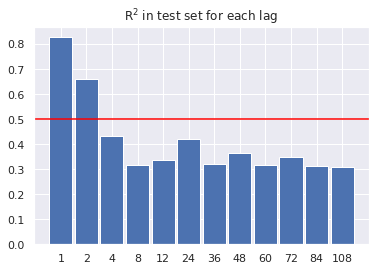

In [14]:
plt.bar([str(i) for i in test_values], r2_test_values, width = 0.9)
plt.axhline(0.5, color = 'red')
plt.title(r"R$^2$ in test set for each lag")
plt.savefig(IMAGES_FOLDER+"r2_test_per_lag.eps")
plt.show()

## Elastic-net Regression

In [9]:
poly = PolynomialFeatures(2)

x_train_SP_poly = pd.DataFrame(poly.fit_transform(x_train_SP), 
                               columns = poly.get_feature_names(x_train_SP.columns), 
                               index = x_train_SP.index)
x_test_SP_poly = pd.DataFrame(poly.fit_transform(x_test_SP), 
                              columns = poly.get_feature_names(x_test_SP.columns),
                              index = x_test_SP.index)

In [87]:
model = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0],
                     alphas = range(1, 20), 
                     cv = 5, 
                     n_jobs = 2)

model.fit(x_train_SP_poly, y_train_o3)

y_pred = model.predict(x_test_SP_poly)

y_train_pred = model.predict(x_train_SP_poly)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

#utility.save_metrics("O3", 8, "elastic_net_regression", 
#                     {'alpha': float(model.alpha_), 'w_l1': model.l1_ratio_},    
#                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8516684349073814
MAE train set: 0.2578780268166075
RMSE train set: 0.35111605610301594
R2 test set: 0.8376312266550836
MAE test set: 0.22412968340950967
RMSE test set: 0.3033920942677412


In [97]:
ind = np.where(model.coef_ != 0)[0]
print(x_train_SP_poly.columns[ind])

Index(['year^2', 'year month', 'year day', 'year Chuva', 'year Pres',
       'year RS', 'year Temp', 'year UR', 'year Dir_Vento', 'year Vel_Vento',
       'year weekend', 'year season', 'year hour_sin', 'year hour_cos',
       'year CO_lag2', 'year CO_lag24', 'year O3_lag1', 'year O3_lag2',
       'year O3_lag24', 'year O3_MA24', 'year PM10_lag1', 'year PM10_lag2',
       'year PM10_lag24', 'year PM10_MA24'],
      dtype='object')


In [98]:
print("Proportion of non zero coefficients: {}".format(ind.shape[0]/model.coef_.shape[0]))

Proportion of non zero coefficients: 0.06349206349206349


In [99]:
residuals = y_train_pred - y_train_o3
print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

Skew: 0.22870629624086342
Kurt: 2.7990550731638355
Jarque-Bera: Jarque_beraResult(statistic=18191.362889197648, pvalue=0.0)


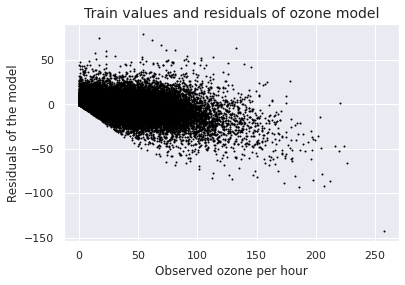

In [33]:
train_trans = pt_gases['O3'].inverse_transform(y_train_o3.values.reshape(-1,1))
pred_trans = pt_gases['O3'].inverse_transform(y_train_pred.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'black')
plt.xlabel("Observed ozone per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of ozone model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

In [40]:
y_pred = pd.Series(y_pred, index = y_test_o3.index)

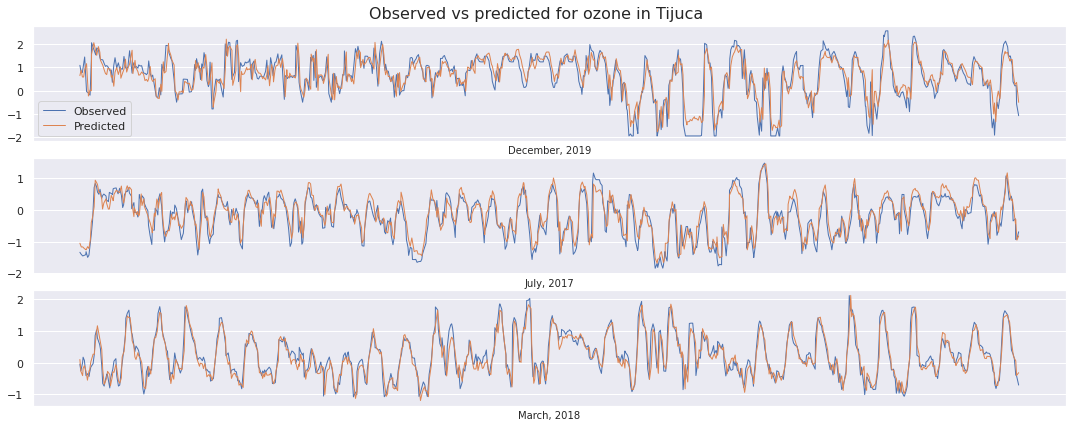

In [41]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_o3[rows1.index], linewidth = 1, label = 'Observed')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted')
ax[1].plot(rows2.index, y_test_o3[rows2.index], linewidth = 1)
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1)
ax[2].plot(rows3.index, y_test_o3[rows3.index], linewidth = 1)
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1)

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for ozone in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 10)
ax[1].set_xlabel("July, 2017", fontsize = 10)
ax[2].set_xlabel("March, 2018", fontsize = 10)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

## Feature Selection + Linear regression

In [53]:
regr = LinearRegression()

best_features = utility.forward_selection(data = x_train_SP_poly, 
                                          target = y_train_o3,
                                          regr = regr, 
                                          k_fold = 5, 
                                          threshold = 0.001
                                         )

In [54]:
print(best_features)

['year O3_lag1', 'RS', 'RS hour_cos', 'year Vel_Vento', 'O3_lag2', 'year O3_MA24', 'hour_cos PM10_lag1', 'RS Temp', 'RS O3_lag2', 'O3_lag1^2']


In [63]:
x_train_SP_sm = sm.add_constant(x_train_SP_poly[best_features])
x_test_SP_sm = sm.add_constant(x_test_SP_poly[best_features])

reg = sm.OLS(y_train_o3, x_train_SP_sm)
res = reg.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     O3   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 3.249e+04
Date:                Sat, 19 Jun 2021   Prob (F-statistic):               0.00
Time:                        23:24:29   Log-Likelihood:                -19246.
No. Observations:               54290   AIC:                         3.851e+04
Df Residuals:                   54279   BIC:                         3.861e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0889      0

In [64]:
y_pred = res.predict(x_test_SP_sm)

y_train_pred = res.predict(x_train_SP_sm)

r2_train = r2_score(y_train_o3, y_train_pred)
r2_test  = r2_score(y_test_o3, y_pred)
mae_train = mean_absolute_error(y_train_o3, y_train_pred)
mae_test  = mean_absolute_error(y_test_o3, y_pred)
rmse_train = mean_squared_error(y_train_o3, y_train_pred, squared = False)
rmse_test  = mean_squared_error(y_test_o3, y_pred, squared = False)

utility.save_metrics("O3", 8, "ffs_linear_regression", 
                     {'threshold': 0.001, 'best_features': best_features},    
                     r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)
 
utility.print_results(r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test)

R2 train set: 0.8568525486205607
MAE train set: 0.25105556691538305
RMSE train set: 0.34492582378790887
R2 test set: 0.8476290071863612
MAE test set: 0.21222743016951673
RMSE test set: 0.29390309102639167


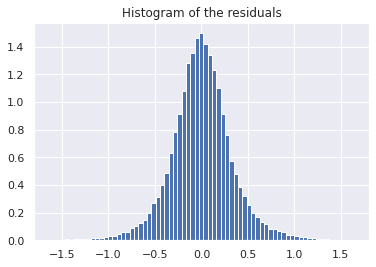

Skew: 0.142077714419295
Kurt: 3.0631685326062343
Jarque-Bera: Jarque_beraResult(statistic=21402.330786724535, pvalue=0.0)


In [59]:
residuals = y_train_pred - y_train_o3
plt.hist(residuals, bins = 100, density = True)
plt.xlim((-1.8,1.8))
plt.title("Histogram of the residuals")
plt.show()

print("Skew: {}".format(residuals.skew()))
print("Kurt: {}".format(residuals.kurt()))
print("Jarque-Bera: {}".format(jarque_bera(residuals)))

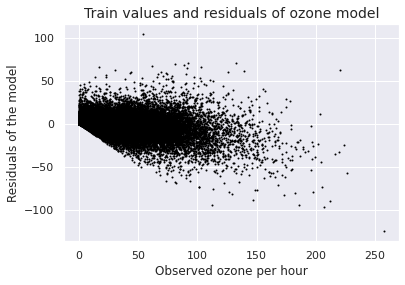

In [82]:
train_trans = pt_gases['O3'].inverse_transform(y_train_o3.values.reshape(-1,1))
pred_trans = pt_gases['O3'].inverse_transform(y_train_pred.values.reshape(-1,1))
residuals = pred_trans - train_trans

plt.scatter(train_trans, residuals, s=1, color = 'black')
plt.xlabel("Observed ozone per hour")
plt.ylabel("Residuals of the model")
plt.title("Train values and residuals of ozone model", fontsize = 14)
#plt.savefig(IMAGES_FOLDER+"observed-vs-residuals-linear-regression.eps", bbox_inches = 'tight')
plt.show()

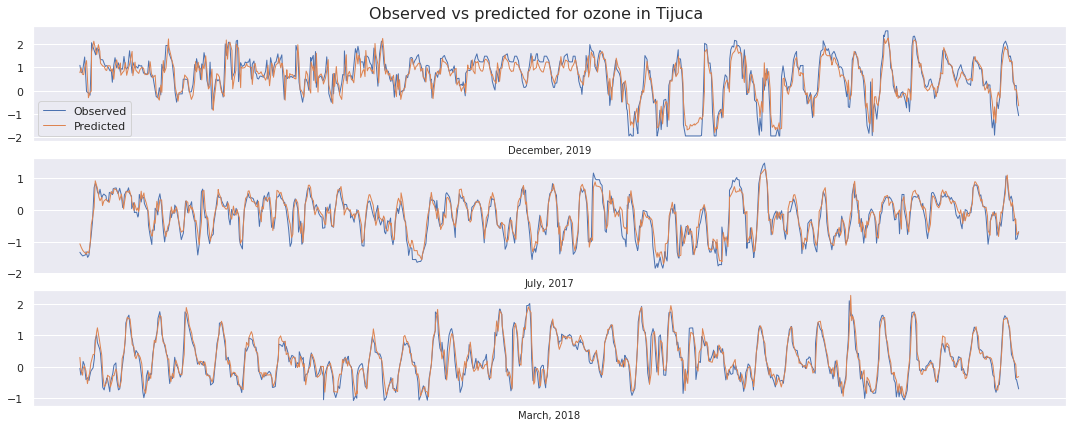

In [83]:
rows1 = x_test_SP[(x_test_SP.year==2019)&(x_test_SP.month==12)]
rows2 = x_test_SP[(x_test_SP.year==2017)&(x_test_SP.month==7)]
rows3 = x_test_SP[(x_test_SP.year==2018)&(x_test_SP.month==3)]

fig, ax = plt.subplots(3,1,figsize = (15,6))

ax[0].plot(rows1.index, y_test_o3[rows1.index], linewidth = 1, label = 'Observed')
ax[0].plot(rows1.index, y_pred[rows1.index], linewidth = 1, label = 'Predicted')
ax[1].plot(rows2.index, y_test_o3[rows2.index], linewidth = 1)
ax[1].plot(rows2.index, y_pred[rows2.index], linewidth = 1)
ax[2].plot(rows3.index, y_test_o3[rows3.index], linewidth = 1)
ax[2].plot(rows3.index, y_pred[rows3.index], linewidth = 1)

ax[0].set_xticks([], minor=False)
ax[1].set_xticks([], minor=False)
ax[2].set_xticks([], minor=False)

fig.suptitle("Observed vs predicted for ozone in Tijuca", fontsize = 16)
fig.tight_layout(rect=[0, 0.03, 1, 1.02])

ax[0].set_xlabel("December, 2019", fontsize = 10)
ax[1].set_xlabel("July, 2017", fontsize = 10)
ax[2].set_xlabel("March, 2018", fontsize = 10)

ax[0].legend()

#plt.savefig(IMAGES_FOLDER+"observed-fitting-ozone-tijuca.eps", bbox_inches='tight')
del rows1,rows2,rows3

## Support vector machine

In [ ]:
regr = make_pipeline(StandardScaler(), 
                     LinearSVR(random_state=0, tol=1e-5, max_iter = 100000))

regr.fit(x_train_AV, y_train_AV)

In [ ]:
y_pred_train_AV = regr.predict(x_train_AV)
y_pred_AV = regr.predict(x_test_AV)

In [ ]:
print("R2 train set: {}".format(r2_score(y_train_AV, y_pred_train_AV)))
print("MAE train set: {}".format(mean_absolute_error(y_train_AV, y_pred_train_AV)))
print("RMSE train set: {}".format(mean_squared_error(y_train_AV, y_pred_train_AV, squared = False)))

print("R2 test set: {}".format(r2_score(y_test_AV, y_pred_AV)))
print("MAE test set: {}".format(mean_absolute_error(y_test_AV, y_pred_AV)))
print("RMSE test set: {}".format(mean_squared_error(y_test_AV, y_pred_AV, squared = False)))